# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [118]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib

from Functions import *

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

# Code from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
buffer_size_m = 200

## Read in formatted data

In [133]:
data = pd.read_csv("../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m), index_col = False)

## Aggreate data from all sensors

In [135]:
data = data.fillna(0)
data = data[['sensor_id', 'datetime', 'year', 'month', 'day', 'time', 'hourly_counts', 'time_of_day', 'day_of_month_num', 
       'weekday_num', 'month_num', 'Temp', 'Humidity', 'Pressure', 'Rain', 'WindSpeed','public_holiday', 'school_holiday',
       'Sin_time', 'Cos_time', 'Sin_month_num', 'Cos_month_num','Sin_weekday_num', 'Cos_weekday_num', 
             'Rainfall amount (millimetres)','school_holiday','public_holiday'  ]]

In [136]:
# Get features other than count data, and keep one version of each row (so we have one row per hour)
all_sensors_other_data = data.copy()
all_sensors_other_data.drop(['hourly_counts', 'sensor_id'], axis=1,inplace=True)
all_sensors_other_data = all_sensors_other_data.drop_duplicates(subset=['datetime','day_of_month_num', 'weekday_num'], keep='last')

# Get the count features, and find the sum of the values across all sensors
all_sensors_hourly_counts = data[['datetime', 'hourly_counts']]
all_sensors_hourly_counts =all_sensors_hourly_counts.groupby("datetime").sum()

# Join the two together
all_sensors_other_data['hourly_counts'] = all_sensors_hourly_counts['hourly_counts'].values

In [137]:
data = all_sensors_other_data.copy()

### Add a random variable (to compare performance of other variables against)

In [131]:
rng = np.random.RandomState(seed=42)
data['random'] = np.random.random(size=len(data))
data["random_cat"] = rng.randint(3, size=data.shape[0])

### Date based variables: Option 1 - Use the Cos/sin cyclical variable versions

In [ ]:
data_time_columns = data[['day_of_month_num', 'time', 'weekday_num', 'time_of_day']]
data = data.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

### Date based variables: Option 2 - Create Dummy Variables

In [145]:
# for date_col in ['day', 'year', 'month',]:
#     date_col_dummy =  pd.get_dummies(data[date_col], drop_first = True)
#     if date_col =='month':
#         date_col_dummy.columns= prepend(date_col_dummy.columns.values, 'month_')
#     if date_col =='year':
#         date_col_dummy.columns= prepend(date_col_dummy.columns.values, 'year_')
#     data = pd.concat([data, date_col_dummy],axis=1)
#     del data[date_col]
# # data_time_columns = data[['time']]
# data = data.drop(['datetime', 'time_of_day',  'time', 'weekday_num','month_num','Sin_month_num', 'Cos_month_num',
#        'Sin_weekday_num', 'Cos_weekday_num', "day_of_month_num" ],axis=1)

## Prepare data for modelling 
### Split into predictor/predictand variables

In [148]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

### Store the (non Sin/Cos) time columns and then remove them
Need them later to segment the results by hour of the day

In [35]:
# data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day']]
# Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [149]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 32)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 200)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [150]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Define regex's to remove columns not needed in various splits of removing column

In [151]:
column_regex_dict = {'withsubtypes':'buildings$|furniture$|landmarks$'}

### Loop through each combination of the models, and the variables to include in the modelling

In [152]:
# for i in range(4,13):
#     print(i)
#     del Xfull['month_{}'.format(i)]

In [153]:
# Dataframe to store the scores for each model
error_metric_scores = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
predictions_df = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
feature_importance_scores ={}

models_dict = {
    "linear_regressor": lr_model_pipeline,
    "xgb_regressor":xgb_model_pipeline, 
               "rf_regressor":rf_model_pipeline,
#                "et_regressor":et_model_pipeline
}
# models_dict = {"rf_regressor":rf_model_pipeline}
for model_name,model in models_dict.items():
    for regex_name, regex in column_regex_dict.items():
        print(model_name)
        # Run the model: return the estimators and a dataframe containing evaluation metrics
        estimators, error_metrics_df, feature_list, predictions = run_model_with_cv_and_predict(
            model, model_name, error_metrics, cv_parameters, Xfull, Yfull, regex_name, regex) 
        # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
        error_metric_scores = error_metric_scores.append(error_metrics_df)
        
        predictions_df[model_name] =predictions
        
        # Create dataframe of feature importances (no feature importances for linear regression)
        if model_name != 'linear_regressor':
            feature_importances = pd.DataFrame(index =[feature_list])
            for idx,estimator in enumerate(estimators):
                    feature_importances['Estimator{}'.format(idx)] = estimators[idx][model_name].feature_importances_
            feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances
            
#         filename = 'PickleFiles/CV/{}_aggregatedmodel/{}_cv_estimators.pkl'.format(buffer_size_m, model_name)
#         joblib.dump(estimators, filename)

linear_regressor
Running linear_regressor model, variables include withsubtypes
Ran in 0 minutes
xgb_regressor
Running xgb_regressor model, variables include withsubtypes
Ran in 3 minutes
rf_regressor
Running rf_regressor model, variables include withsubtypes
Ran in 2 minutes


### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

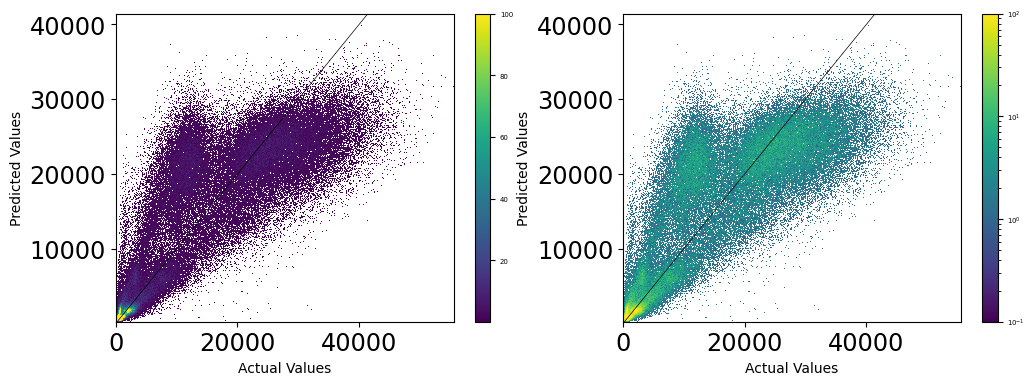

In [154]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

### Print the accuracy scores

In [155]:
error_metric_scores

,mae,map,r2,rmse
linear_regressor_withsubtypes,6056.55,9.955042e+14,0.56,7768.26
xgb_regressor_withsubtypes,4890.50,9.831131e+14,0.67,6702.10
rf_regressor_withsubtypes,4772.10,1.480950e+14,0.68,6615.35


### Feature importances from within cross-validation
If reporting feature importances from the model, then would use those from fitting the final model on the full dataset. However, this is useful as a measure of the stability of the feature importances that the model reports

In [156]:
feature_importances_df = feature_importance_scores["rf_regressor_withsubtypes"].copy()
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'level_0':'Variable'},inplace=True)

#### Top 10 features for each estimator

In [157]:
important_columns=pd.DataFrame()
for column in feature_importances_df.columns[1:]:
    this_col = feature_importances_df[['Variable', column]]
    important_columns[column] = this_col.sort_values(column, ascending = False)['Variable'].tolist()[0:10]
important_columns    

,Estimator0,Estimator1,Estimator2,Estimator3,Estimator4,Estimator5,Estimator6,Estimator7,Estimator8,Estimator9
0,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time
1,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time
2,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure
3,WindSpeed,Humidity,Humidity,WindSpeed,Humidity,Humidity,WindSpeed,Humidity,Humidity,Humidity
4,Humidity,WindSpeed,WindSpeed,Humidity,WindSpeed,WindSpeed,Humidity,WindSpeed,WindSpeed,WindSpeed
5,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp
6,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num
7,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num
8,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num
9,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num


In [70]:
pi_raw = []
pi_ls = []
for estimator in estimators[:3]:
    pi, pi_raw = find_permutation_importance(estimator['rf_regressor'], Xfull, Yfull, n_iter=3)  
    pi_ls.append(pi)
    pi_raw.append(pi_raw)

### Find permutation importance from within Cross validation

In [72]:
important_columns=pd.DataFrame()
for i in list(range(0,len(pi_ls))):
    test=pi_ls[i].sort_values('importance', ascending = False)[0:25]
    test.reset_index(inplace=True, drop=True)
    important_columns["PI{}".format(i)] = test['feature']
important_columns

,PI0,PI1,PI2
0,Cos_time,Cos_time,Cos_time
1,Sin_time,Sin_time,Sin_time
2,Humidity,WindSpeed,Humidity
3,WindSpeed,Humidity,WindSpeed
4,Temp,Temp,Temp
5,Rainfall amount (millimetres),random_cat,random
6,random_cat,school_holiday,random_cat
7,Saturday,Rain,Saturday
8,public_holiday,public_holiday,public_holiday
9,school_holiday,school_holiday,school_holiday


### Find the error in the predictions broken down by hour and sensor

In [107]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'],'AbsolouteError':abs(Yfull-predictions),
                 'Error':predictions-Yfull})

# Remove rows where the real val is 0
df = df[df['Real_vals']!=0]

# Add percent (not absoloute error)
df['%Error']=df['Error']/df['Real_vals']*100

In [108]:
# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

,Predictions,Real_vals,Hour,Weekday,AbsolouteError,Error,%Error,hour_of_week
805,1642.91,1440,0,1,202.91,202.91,14.090972,w1_h0
3555,2216.76,1044,0,1,1172.76,1172.76,112.333333,w1_h0
6276,2157.05,1054,0,1,1103.05,1103.05,104.653700,w1_h0
8980,1997.52,1316,0,1,681.52,681.52,51.787234,w1_h0
11699,2453.19,1514,0,1,939.19,939.19,62.033686,w1_h0


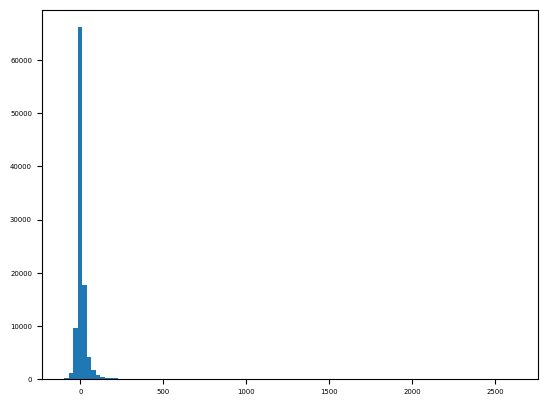

In [109]:
plt.hist(df['%Error'],bins=100);

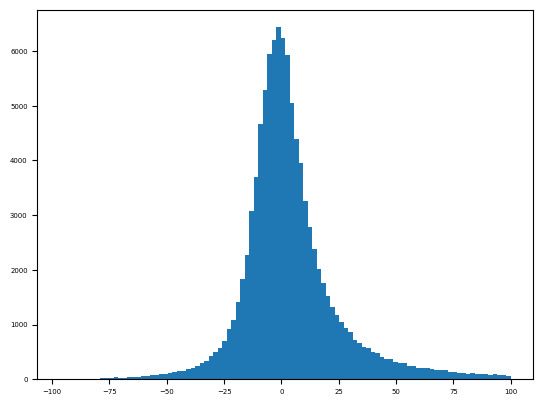

In [114]:
# plt.hist(df['%Error'],bins=50);
under_5 = df[df['%Error']<100]
over_5 = df[df['%Error']>100]
plt.hist(under_5['%Error'],bins=100);

In [40]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))

## Plot the errors per hour of week

In [41]:
labels = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12',
         '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12',]*7

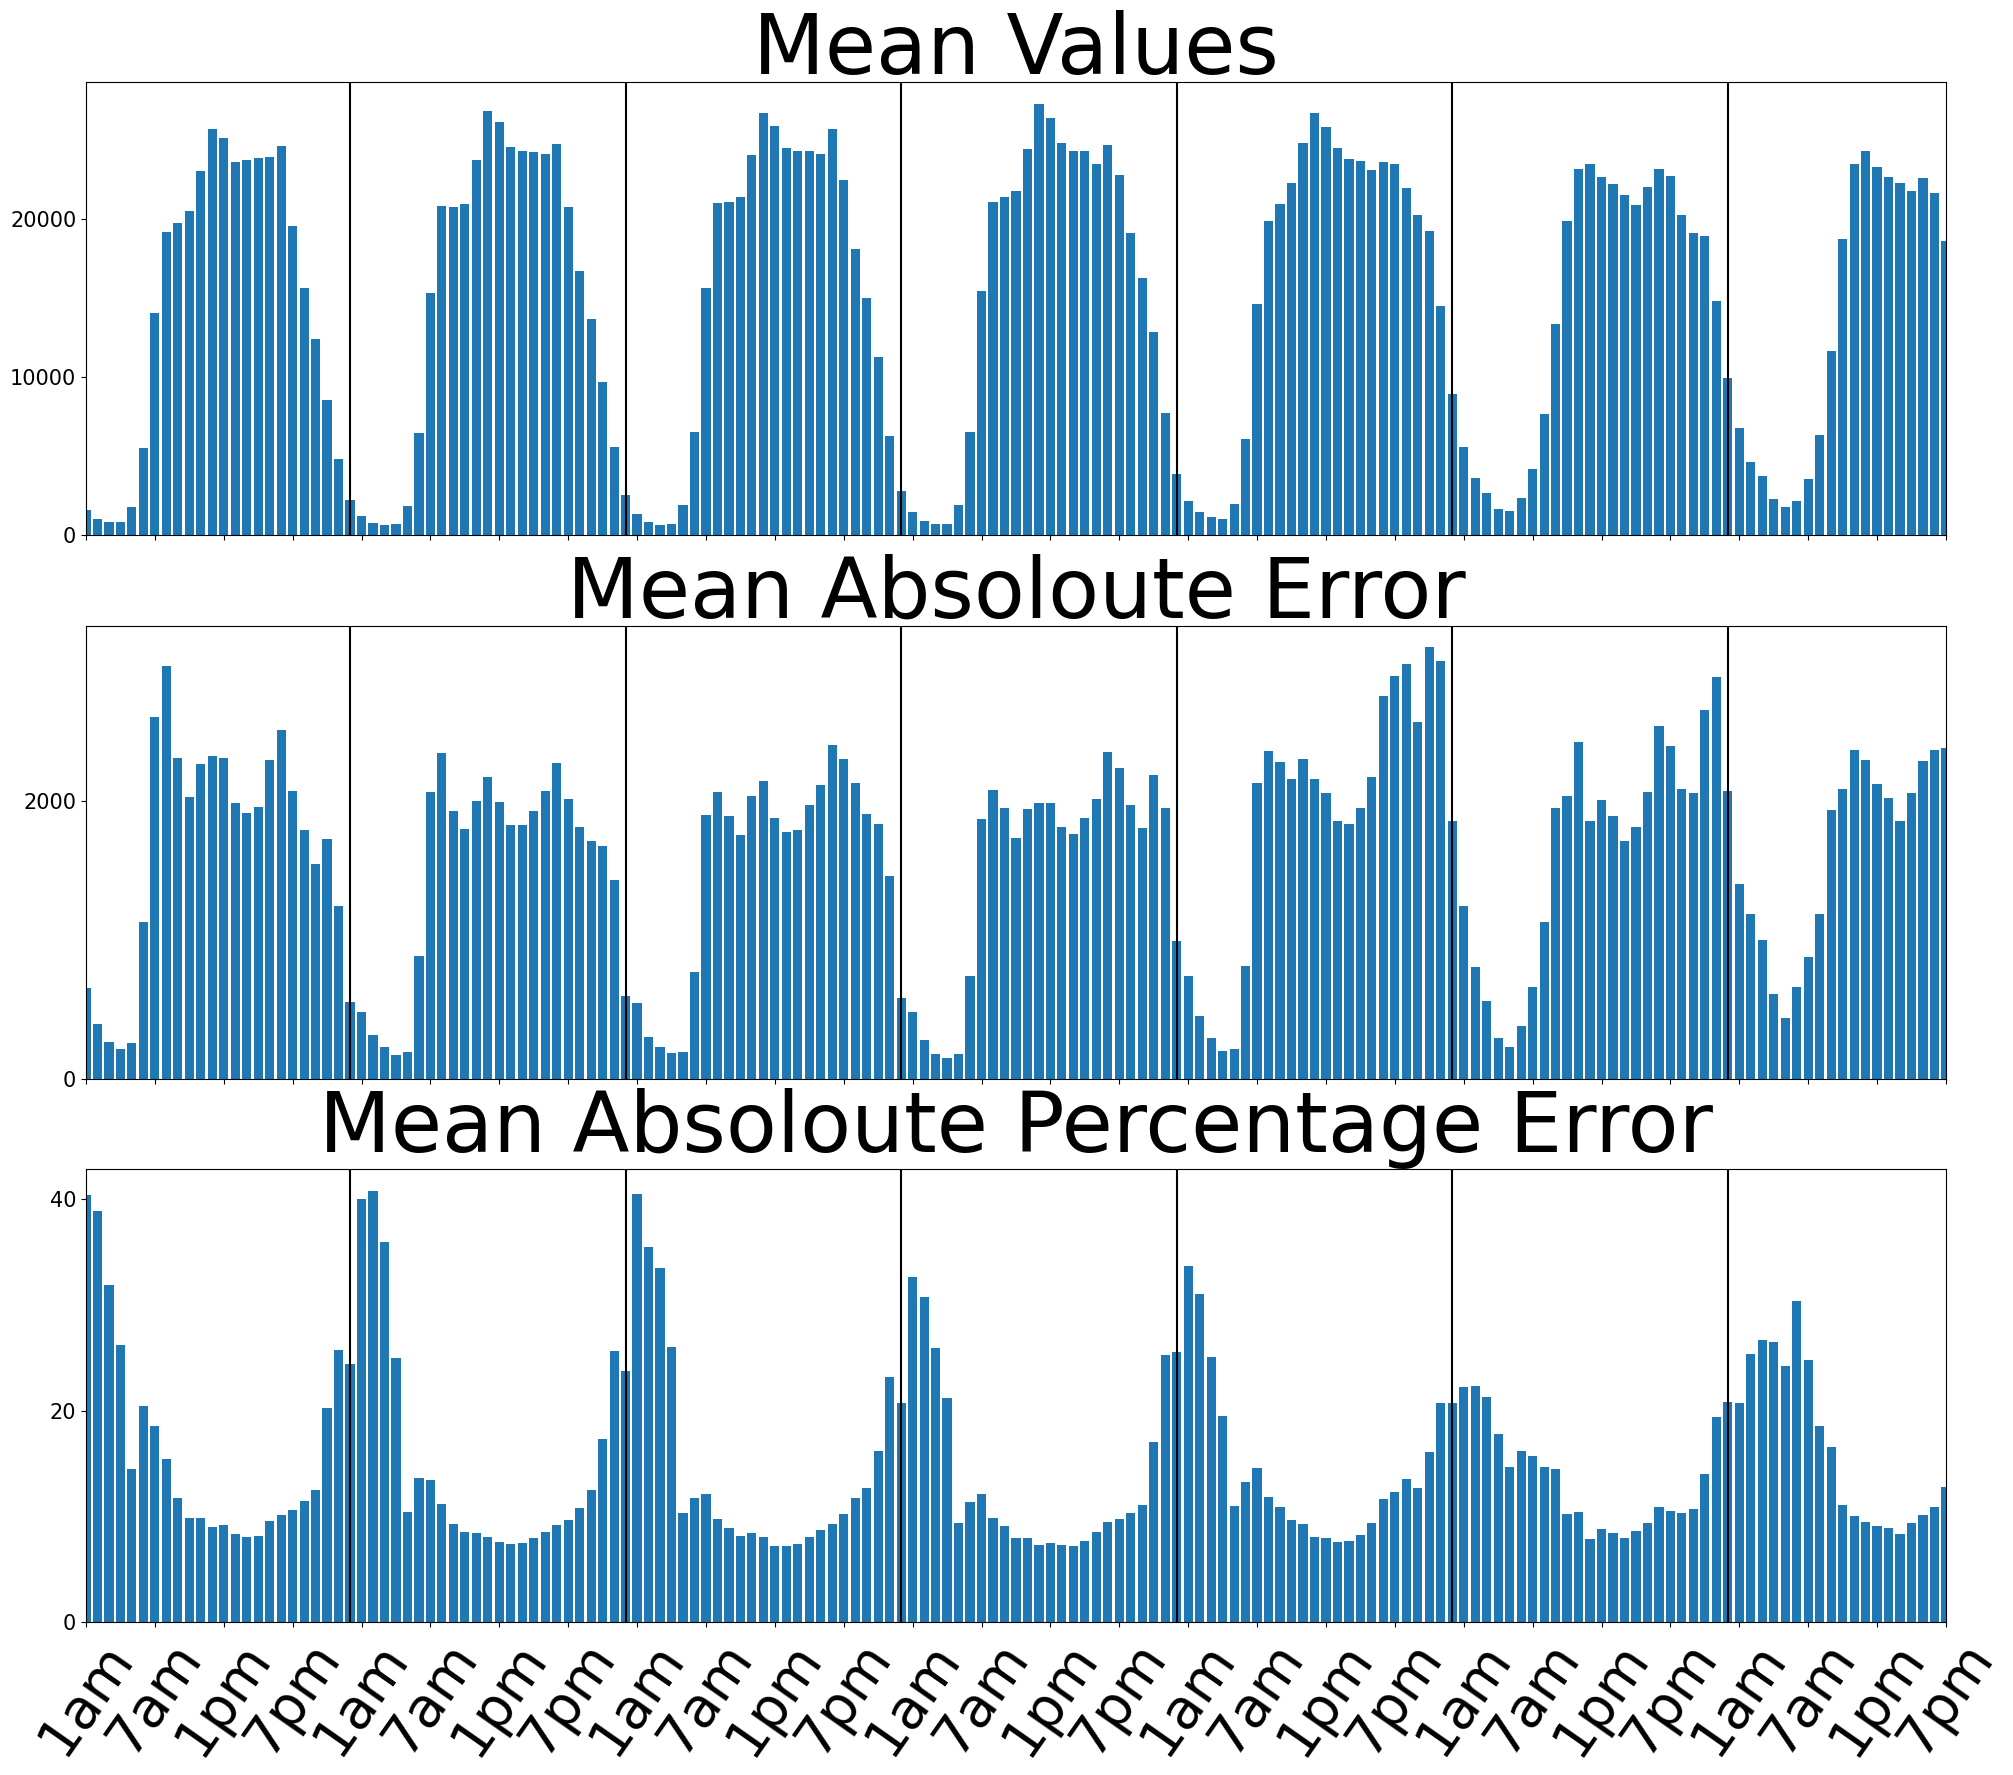

In [63]:
fig,axs =plt.subplots(nrows=3,figsize =(24,20), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means)#,  yerr=hourofweekly_stds  )
axs[0].set_title('Mean Values', fontsize=60)
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes)#, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error', fontsize=60)
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[2].set_title('Mean Absoloute Percentage Error', fontsize=60)
# axs[2].tick_params(axis='x')

# Removes weird whitespace from the start
axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::3])])

# Axis labels
axs[2].set_xticks(list(range(1,len(labels)))[::6], fontsize=40)
axs[2].set_xticklabels(labels[::6], fontsize=40, rotation = 55)

params = {'ytick.labelsize': 50}
plt.rcParams.update(params)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    
fig.savefig('Figs/Errors/Error_by_hour_of_week.pdf')
fig.savefig('Figs/Errors/Error_by_hour_of_week.jpg')

## Plot the errors per hour of day

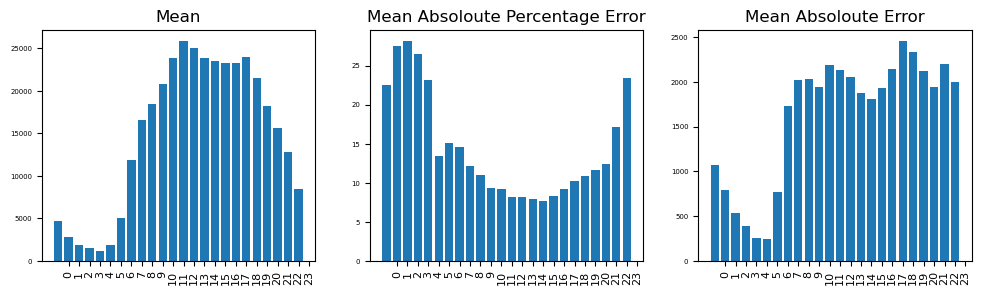

In [69]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[0].set_title('Mean')
axs[1].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[1].set_title('Mean Absoloute Percentage Error');
axs[2].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[2].set_title('Mean Absoloute Error')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

plt.rcParams['ytick.labelsize'] = 5

### Plot the errors by sensor

In [60]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [61]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

In [287]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['Mean'].min(),
                           vmax=melbourne_sensors['Mean'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.Mean), fill_color = linear(row.Mean),
                      ).add_to(melbourne_map)


linear.caption = "Mean hourly values"
linear.add_to(melbourne_map)
melbourne_map

import io
from PIL import Image

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')

In [69]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAPE'].min(), vmax=melbourne_sensors['MAPE'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAPE), fill_color = linear(row.MAPE),
                      ).add_to(melbourne_map)


linear.caption = "Mean Absoloute Percentage Error"
linear.add_to(melbourne_map)
melbourne_map

In [70]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAE'].min(), vmax=melbourne_sensors['MAE'].max())

# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAE), fill_color = linear(row.MAE),
                      ).add_to(melbourne_map)


linear.caption = "Mean Absoloute Error for the sensor"
linear.add_to(melbourne_map)
melbourne_map